# Classifying News Article Bias with LSTM

In [1]:
import sqlite3
import pickle
import numpy as np
import re
import random
from time import strftime, localtime

from keras.preprocessing.text import text_to_word_sequence
from keras.utils import pad_sequences

from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

2023-03-16 12:10:49.023665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 12:10:50.042114: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/andyd/miniconda3/envs/nlp/lib/
2023-03-16 12:10:50.046393: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/andyd/miniconda3/envs/nlp/lib/
2023-03-16 12:10:50.046414: W tensorflow/compiler/tf2t

In [4]:
MAX_ARTICLE_LENGTH = 10000
PAD_VALUE = 0

db = sqlite3.connect('text_encoder.db')
c = db.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS "TextEncoder"(
    "word" TEXT,
    "n" INTEGER,
    PRIMARY KEY("word")
);''')
del c

In [2]:
def get_max_key():
    c = db.cursor()
    c.execute('SELECT MAX(n) FROM TextEncoder;')
    return c.fetchone()[0]

def add_word_encoding(word, key):
    c = db.cursor()
    c.execute('INSERT INTO TextEncoder (word, n) VALUES (?, ?);', (word, key))
    assert c.rowcount > 0, "ERROR Inserting key %10s as word: %20s" % (key, word)
    db.commit()
    return

def get_word_key(word, freeze):
    c = db.cursor()
    c.execute('SELECT n FROM TextEncoder WHERE word = ?;', (word,))
    response = c.fetchone()
    if response is not None:
        return response[0]
    else:
        if freeze:
            return None
        else:
            key = get_max_key() + 1
            add_word_encoding(word, key)
            print('Adding word "%20s" as n: %10i' % (word, key))
            return key

def get_vocab_length():
    c = db.cursor()
    c.execute('SELECT COUNT(*) FROM TextEncoder;')
    return c.fetchone()[0]

def numberize_article(article, freeze):
    tokens = text_to_word_sequence(article)
    num_article = []
    for token in tokens:
        key = get_word_key(token, freeze)
        if key is not None:
            num_article.append(key)
    return np.array(num_article)

def get_nums_word(n):
    c = db.cursor()
    c.execute('SELECT word FROM TextEncoder WHERE n = ?;', (n,))
    word = c.fetchone()
    if word is None:
        return ''
    else:
        return word[0]

In [5]:
def remake_article(num_article):
    text_array = [get_nums_word(n) for n in num_article]
    raw_text = ' '.join(text_array)
    return re.sub(r'\s+', ' ', raw_text)


def parse_articles(articles, max_length=MAX_ARTICLE_LENGTH, min_length=20, verbose=False, freeze=False):
    numerified_articles = []
    removed_articles = set()
    for i, a in enumerate(articles):
        numberized = numberize_article(a, freeze)
        if len(numberized) >= min_length:
            numerified_articles.append(numberized)
        else:
            removed_articles.add(i)
            if verbose:
                print('Removing article: %6i for being too short. Length: %3i' % (i, len(numberized)))
    numerified_articles = np.array(numerified_articles)
    return pad_sequences(numerified_articles, maxlen=max_length, dtype='float32', value=0), removed_articles


def train_test_split(data_in, data_out, train_pct=0.75, validate=True, val_pct_of_test=0.33):
    all_data = list(zip(data_in, data_out))
    random.shuffle(all_data)
    shuffled_in, shuffled_out = zip(*all_data)
    data_length = len(all_data)
    if validate:
        test_split = int(data_length * train_pct)
        val_split = test_split + int((data_length - test_split) * (1 - val_pct_of_test))
        
        train_in = shuffled_in[:test_split]
        test_in = shuffled_in[test_split:val_split]
        val_in = shuffled_in[val_split:]
        
        train_out = shuffled_out[:test_split]
        test_out = shuffled_out[test_split:val_split]
        val_out = shuffled_out[val_split:]
        
        return (np.array(train_in), np.array(train_out)), (np.array(val_in), np.array(val_out)), (np.array(test_in), np.array(test_out))
    else:
        test_split = int(data_length * train_pct)
        train_in = shuffled_in[:test_split]
        train_out = shuffled_out[:test_split]
        test_in = shuffled_in[test_split:]
        test_out = shuffled_out[test_split:]
        return (np.array(train_in), np.array(train_out)), (np.array(test_in), np.array(test_out))


def create_model(encoding_vector_size=100, n_filters=32, kernel_size=3, pool_size=2, add_dropout=True, dropout_pct=0.2):
    model = Sequential()
    model.add(Embedding(
        input_dim=get_vocab_length(),
        output_dim=encoding_vector_size,
        input_length=MAX_ARTICLE_LENGTH
    ))
    if add_dropout:
        model.add(Dropout(dropout_pct))
    model.add(Conv1D(
        filters=n_filters, 
        kernel_size=kernel_size, 
        padding='same', 
        activation='relu'
    ))
    model.add(MaxPooling1D(
        pool_size=pool_size
    ))
    if add_dropout:
        model.add(Dropout(dropout_pct))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    return model

def gen_filename():
    return 'savedModels/article_lstm_model_%s.h5' % strftime('%y%m%d.%H%M%S', localtime())

def get_data_from_db():
    adb = sqlite3.connect('articles.db')
    c = adb.cursor()
    c.execute('SELECT text, right_score FROM SiteScrape;')
    articles, labels = zip(*c.fetchall())
    return articles, np.array(labels).astype('float32')

def save_data(articles, labels):
    data = {
        'articles': articles,
        'labels': labels
    }
    with open('data_save.pickle', 'wb') as f:
        pickle.dump(data, f)
    return

def get_data_from_pickle():
    with open('database.pickle', 'rb') as f:
        data = pickle.load(f)
    articles = data['articles']
    labels   = data['labels']
    return articles, labels

Import the data, parse the articles & labels, and then save them out

In [5]:
# Load
articles, labels = get_data_from_db()

# Process
processed_articles, removed_articles = parse_articles(articles)
labels = np.array([l for i, l in enumerate(labels) if i not in removed_articles])

#Save
save_data(processed_articles, labels)

KeyboardInterrupt: 

*Then* next time you can just load in the already processed data… (assuming nothing has changed)

In [6]:
processed_articles, labels = get_data_from_pickle()

Split out the data into `train`, `validate`, and`test`

In [7]:
(train_in, train_out), (val_in, val_out), (test_in, test_out) = train_test_split(processed_articles, labels)

Now build the model…

In [8]:
model = create_model()

callbacks = [
    EarlyStopping(
        monitor='val_acc', 
        patience=2
    ),
    ModelCheckpoint(
        filepath=gen_filename(), 
        monitor='val_acc', 
        save_best_only=True
    )
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

2023-03-16 11:51:26.293429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-16 11:51:26.348778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-16 11:51:26.348861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-16 11:51:26.350246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

What does the model look like?

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 100)        17328600  
                                                                 
 dropout (Dropout)           (None, 10000, 100)        0         
                                                                 
 conv1d (Conv1D)             (None, 10000, 32)         9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5000, 32)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 5000, 32)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                        

Not starting from scratch? Use the following code instead

In [ ]:
# Enter the filename of the model to load
model_filename = 'savedModels/Compressed_model_190515.002419/demo_model.h5'
model = load_model(model_filename)

Train the model for 3 epochs

In [10]:
hist = model.fit(
    train_in,
    train_out,
    epochs=5,
    batch_size=32,
    validation_data=(val_in, val_out),
    callbacks=callbacks
)

Epoch 1/5


2023-03-16 11:51:51.538225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-16 11:51:52.703365: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f229c237ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-16 11:51:52.703415: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 Super, Compute Capability 7.5
2023-03-16 11:51:52.730930: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-16 11:51:52.996313: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


435/435 [==============================] - 203s 451ms/step - loss: 0.1406 - acc: 0.9449 - val_loss: 0.0501 - val_acc: 0.9726
Epoch 2/5
435/435 [==============================] - 184s 424ms/step - loss: 0.0253 - acc: 0.9884 - val_loss: 0.0340 - val_acc: 0.9876
Epoch 3/5
435/435 [==============================] - 171s 393ms/step - loss: 0.0113 - acc: 0.9948 - val_loss: 0.0369 - val_acc: 0.9902
Epoch 4/5
435/435 [==============================] - 175s 403ms/step - loss: 0.0086 - acc: 0.9953 - val_loss: 0.0394 - val_acc: 0.9876
Epoch 5/5
435/435 [==============================] - 178s 408ms/step - loss: 0.0082 - acc: 0.9958 - val_loss: 0.0475 - val_acc: 0.9850


Evaluate the trained model…

In [11]:
evaluate = model.evaluate(test_in, test_out)
print('History Results:')
print('Loss:     %5.2f\nAccuracy: %5.2f %%' % (evaluate[0], (evaluate[1]*100)))

98/98 [==============================] - 16s 166ms/step - loss: 0.0670 - acc: 0.9794
History Results:
Loss:      0.07
Accuracy: 97.94 %


Plot the history

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

What does the accuracy look like?

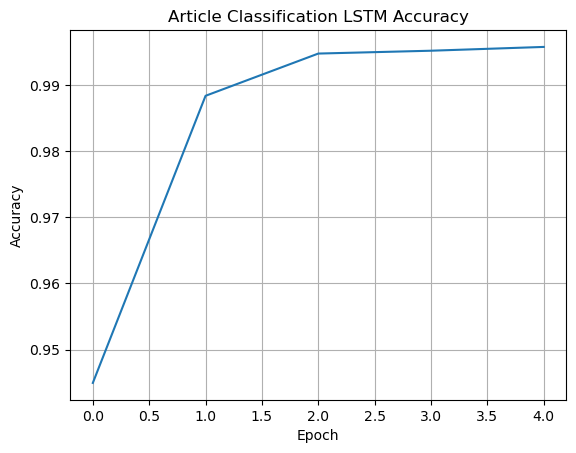

In [13]:
plt.plot(hist.history['acc'])
plt.title('Article Classification LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


What does the loss look like?

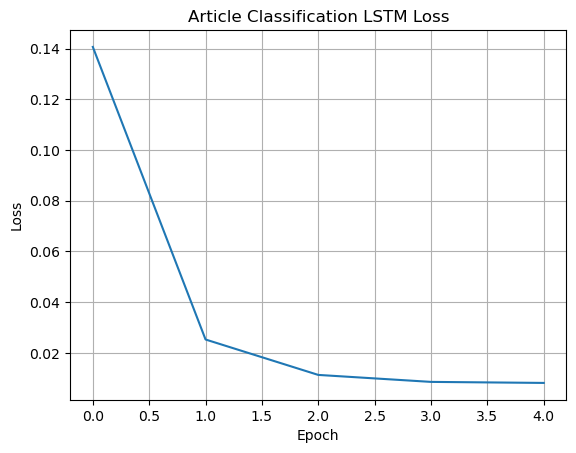

In [14]:
plt.plot(hist.history['loss'])
plt.title('Article Classification LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()


## Testing the Network

In [6]:
import re
import requests
from bs4 import BeautifulSoup
from keras.models import load_model

In [7]:
model = load_model('savedModels/article_lstm_model_230316.115129.h5')

2023-03-16 12:11:30.891268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-16 12:11:30.936999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-16 12:11:30.937078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-16 12:11:30.937831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [8]:
def clean_text(raw_text, to_lower=True):
    text = re.sub(r'(https|http):[^\s]*', ' ', raw_text)
    text = re.sub('[' + re.escape('#@!"$%&(\')*+,-./:;<=>?[\\]^_`{|}~') + ']', '', text)
    text = text.encode('utf8').decode('ascii','ignore')
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text.lower()

def scrape_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, features='lxml')
    p_tags = soup.find_all('p')
    raw_text = ' '.join([p.text for p in p_tags])
    text = clean_text(raw_text)
    return text

def make_prediction(text, model=model):
    parsed_article, _ = parse_articles([text], min_length=0, freeze=True)
    if len(parsed_article) < 1:
        print('Sorry! It looks like once I processed that article, it was too short to use. :\'(')
        return
    print('🤔 Let me think…')
    prediction = model.predict(parsed_article)
    prediction_pct = prediction[0] * 100
    print('''\n   ------------------------------------------------------------------------------------------\n  |   I\'d say that there\'s a %5.2f%% chance that your article is from a right-leaning source. |\n  |  ----------------------------------------------------------------------------------------\n  |/\n🖥️\n''' % prediction_pct)
    return

Enter a URL below to test out the model!

In [10]:
url = input('Enter a url: ').strip()
print('\n\n')
make_prediction(url)




🤔 Let me think…
1/1 [==============================] - 0s 279ms/step

   ------------------------------------------------------------------------------------------
  |   I'd say that there's a 99.71% chance that your article is from a right-leaning source. |
  |  ----------------------------------------------------------------------------------------
  |/
🖥️



In [11]:
test_urls = ['https://www.washingtonpost.com/politics/2023/03/15/trump-fox-news-dominion-defamation-lawsuit/',
        'https://www.washingtonpost.com/politics/2023/03/15/biden-medicare-prescription-drugs-fight/']
for i in test_urls:
    make_prediction(i)

🤔 Let me think…
1/1 [==============================] - 0s 162ms/step

   ------------------------------------------------------------------------------------------
  |   I'd say that there's a 99.71% chance that your article is from a right-leaning source. |
  |  ----------------------------------------------------------------------------------------
  |/
🖥️

🤔 Let me think…
1/1 [==============================] - 0s 258ms/step

   ------------------------------------------------------------------------------------------
  |   I'd say that there's a 76.57% chance that your article is from a right-leaning source. |
  |  ----------------------------------------------------------------------------------------
  |/
🖥️

